# <div style="text-align:center">Final Assignmeint in Coursera Capstone course</div>
## Exploring different cuisines (restaurants) in boroughs and neighborhoods in Toronto
## This notebook contains all calculations and visualization data which was used to cluster Toronto boroughs dependind on restaurant data from FourSquares


### 0. First: Installation of the all packages for work

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c districtdatalabs yellowbrick
!pip install folium==0.5.0
!pip install yellowbrick

### 0. And importing needed modules

In [2]:
import pandas as pd
import folium
from folium import plugins
import requests
import json
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from PIL import Image
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

### 1. I used the dataset with postal codes, borougs and neighborhoods in Toronto, Canada.
### For the geospatial data I used the dataframe provided for this course.

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df=df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index()
df['Neighbourhood']=df['Neighbourhood'].replace('Not assigned',df['Borough'])
url='http://cocl.us/Geospatial_data'
gd=pd.read_csv(url)
gd.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df.set_index('Postcode', inplace=True)
gd.set_index('Postcode', inplace=True)
mergedDf = df.merge(gd, left_index=True, right_index=True)
mergedDf=mergedDf.reset_index()
mergedDf.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

### 2. It's easy to show all boroughs on map using folium package. The boroughs and FSA codes are labelled on map.

In [4]:
latitude=43.653226
longitude=-79.383184

#‘OpenStreetMap’, ‘cartodbpositron’, ‘cartodbdark_matter’

toronto_all=mergedDf.copy()
print(toronto_all.shape)

map_dots = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='cartodbdark_matter')
# add markers to map
for lat, lng, borough, neighborhood, fsa in zip(toronto_all['Latitude'], toronto_all['Longitude'], toronto_all['Borough'], toronto_all['Neighbourhood'], toronto_all['Postcode']):
    label = '{}, {}'.format(borough, fsa)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#01ffff',
        fill=True,
        fill_color='#3d3c42',
        fill_opacity=0.7,
        line_opacity=0.2,
        parse_html=False).add_to(map_dots)  
    
map_dots

(103, 5)


### 3. Next I'm going to use Foursquares API to gather information abo

In [5]:
# The code was removed by Watson Studio for sharing.

### 4. I copied previous dataframe with all data to new dataframe and call it bn_data.

In [6]:
bn_data = mergedDf.copy()
bn_data.rename(columns={'Postcode':'FSA'}, inplace=True)
bn_data.head()

FSA      Borough                         Neighbourhood   Latitude  \
0  M1B  Scarborough                         Rouge,Malvern  43.806686   
1  M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2  M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3  M1G  Scarborough                                Woburn  43.770992   
4  M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

### 5. Here is a function to get nearby venues using search query and add it to the dataframe.

In [7]:
def getNearbyRestaurants(fsa, boroughs, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for fsa, borough, name, lat, lng in zip(fsa,boroughs, names, latitudes, longitudes):
        print(fsa,' ',borough,' ',name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            fsa,
            borough,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['FSA',
                             'Borough',
                             'Neighbourhood',
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [8]:
bn_restaurants = getNearbyRestaurants(fsa=bn_data['FSA'],
                                      boroughs=bn_data['Borough'],
                                      names=bn_data['Neighbourhood'],
                                      latitudes=bn_data['Latitude'],
                                      longitudes=bn_data['Longitude']
                                  )

M1B   Scarborough   Rouge,Malvern
M1C   Scarborough   Highland Creek,Rouge Hill,Port Union
M1E   Scarborough   Guildwood,Morningside,West Hill
M1G   Scarborough   Woburn
M1H   Scarborough   Cedarbrae
M1J   Scarborough   Scarborough Village
M1K   Scarborough   East Birchmount Park,Ionview,Kennedy Park
M1L   Scarborough   Clairlea,Golden Mile,Oakridge
M1M   Scarborough   Cliffcrest,Cliffside,Scarborough Village West
M1N   Scarborough   Birch Cliff,Cliffside West
M1P   Scarborough   Dorset Park,Scarborough Town Centre,Wexford Heights
M1R   Scarborough   Maryvale,Wexford
M1S   Scarborough   Agincourt
M1T   Scarborough   Clarks Corners,Sullivan,Tam O'Shanter
M1V   Scarborough   Agincourt North,L'Amoreaux East,Milliken,Steeles East
M1W   Scarborough   L'Amoreaux West
M1X   Scarborough   Upper Rouge
M2H   North York   Hillcrest Village
M2J   North York   Fairview,Henry Farm,Oriole
M2K   North York   Bayview Village
M2L   North York   Silver Hills,York Mills
M2M   North York   Newtonbrook,Will

### 6. Here is a function to eject short venue name from column with full json string with category data.

In [9]:
def get_category_type(row):
    try:
        categories_list = row['Venue Category']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['shortName']

# filter the category for each row
bn_restaurants['Venue Category'] = bn_restaurants.apply(get_category_type, axis=1)

In [10]:
print(bn_restaurants.shape)
bn_restaurants.head()

(577, 9)


FSA      Borough                    Neighbourhood  Neighbourhood Latitude  \
0  M1E  Scarborough  Guildwood,Morningside,West Hill               43.763573   
1  M1H  Scarborough                        Cedarbrae               43.773136   
2  M1H  Scarborough                        Cedarbrae               43.773136   
3  M1H  Scarborough                        Cedarbrae               43.773136   
4  M1H  Scarborough                        Cedarbrae               43.773136   

   Neighbourhood Longitude                             Venue  Venue Latitude  \
0               -79.188711  Wonder Season Chinese Restaurant       43.765354   
1               -79.239476                Terry's Restaurant       43.774702   
2               -79.239476               Federick Restaurant       43.774697   
3               -79.239476          Terry's Restaurant & Bar       43.774780   
4               -79.239476                terry's restaurant       43.774969   

   Venue Longitude Venue Category  
0       -79.190536           None  
1       -79.241175           None  
2       -79.241142          Hakka  
3       -79.241043     Restaurant  
4       -79.240872        Italian

### 7. I saw that my DF has None values and some values that are not exactly restaurants.

In [11]:
bn_restaurants['Venue Category'].unique()

array([None, 'Hakka', 'Restaurant', 'Italian', 'Thai', 'Indian',
       'Chinese', 'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches',
       'Furniture / Home', 'Asian', 'Diner', 'Japanese', 'Café',
       'Eastern European', 'American', 'Sushi', 'African', 'Caribbean',
       'Lounge', 'Persian', 'Lebanese', 'Mediterranean', 'Greek',
       'Ice Cream', 'Music Venue', 'Entertainment', 'Tapas',
       'New American', 'Fast Food', 'Movie Theater', 'Pub', 'Ethiopian',
       'Dim Sum', 'Theme Restaurant', 'Gastropub', 'Modern European',
       'Spanish', 'Mongolian', 'Molecular Gastronomy', 'Food', 'Beer Bar',
       'Bar', 'Szechuan', 'Vietnamese', 'French', 'Wine Bar',
       'Deli / Bodega', 'Brewery', 'Steakhouse', 'Noodles', 'Nightclub',
       'Vegetarian / Vegan', 'Cantonese', 'Dumplings', 'Portuguese',
       'Mexican', 'Cuban', 'Nightlife', 'Latin American', 'Pizza'],
      dtype=object)

### 8. I washed away all non-restaurant data and saved only restaurants with cuisines.

In [12]:
bn_restaurants=bn_restaurants.dropna()
bn_restaurants.drop(bn_restaurants[(bn_restaurants['Venue Category']=='Furniture / Home') | 
                                   (bn_restaurants['Venue Category']=='Movie Theater') | 
                                   (bn_restaurants['Venue Category']=='Nightclub') | 
                                   (bn_restaurants['Venue Category']=='Nightlife') | 
                                   (bn_restaurants['Venue Category']=='Entertainment') |
                                   (bn_restaurants['Venue Category']=='Music Venue')].index,inplace=True)

In [13]:
bn_restaurants['Venue Category'].unique()

array(['Hakka', 'Restaurant', 'Italian', 'Thai', 'Indian', 'Chinese',
       'Breakfast', 'Middle Eastern', 'Korean', 'Sandwiches', 'Asian',
       'Diner', 'Japanese', 'Café', 'Eastern European', 'American',
       'Sushi', 'African', 'Caribbean', 'Lounge', 'Persian', 'Lebanese',
       'Mediterranean', 'Greek', 'Ice Cream', 'Tapas', 'New American',
       'Fast Food', 'Pub', 'Ethiopian', 'Dim Sum', 'Theme Restaurant',
       'Gastropub', 'Modern European', 'Spanish', 'Mongolian',
       'Molecular Gastronomy', 'Food', 'Beer Bar', 'Bar', 'Szechuan',
       'Vietnamese', 'French', 'Wine Bar', 'Deli / Bodega', 'Brewery',
       'Steakhouse', 'Noodles', 'Vegetarian / Vegan', 'Cantonese',
       'Dumplings', 'Portuguese', 'Mexican', 'Cuban', 'Latin American',
       'Pizza'], dtype=object)

In [14]:
cuisines=('Chinese', 'Japanese', 'Italian', 'Asian','American', 'Indian', 'Caribbean', 'Thai', 'New American',
       'Vietnamese', 'Greek', 'Middle Eastern','Mongolian', 'Korean', 'Spanish',
       'Latin American', 'Eastern European', 'Szechuan', 'French', 'African', 'Mexican',
       'Modern European', 'Portuguese', 'Hakka', 'Cuban', 'Ethiopian', 'Persian',
    'Deli / Bodega', 'Lebanese', 'Cantonese', 'Mediterranean')

In [15]:
print('There are {} uniques categories.'.format(len(bn_restaurants['Venue Category'].unique())))
print('There are {} uniques boroughs.'.format(len(bn_restaurants['Borough'].unique())))
print('There are {} uniques neighborhoods.'.format(len(bn_restaurants['Neighbourhood'].unique())))
print('There are {} venues.'.format((bn_restaurants['Venue'].count())))

There are 56 uniques categories.
There are 10 uniques boroughs.
There are 57 uniques neighborhoods.
There are 557 venues.


### 9.  I was interested in visualization of restaurants count in each borough so I decided to draw a choropleth map.
### There was no geojson file on the internet so I did it myself using this tutorial: [Tutorial](https://medium.com/dataexplorations/generating-geojson-file-for-toronto-fsas-9b478a059f04)
### You can find my final geojson file in my Github repository, feel free to use it!

In [16]:
bn_grouped=bn_restaurants.copy()
bn_grouped=bn_grouped[bn_grouped['Venue Category'].isin(cuisines)]
bn_grouped=bn_grouped.groupby(['FSA'])['Venue'].count().reset_index()
bn_grouped.rename(columns={'Venue':'Count'}, inplace=True)
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
bn_grouped.head()

FSA  Count
0  M1H      3
1  M1P      2
2  M1R      1
3  M1S      2
4  M1T      3

In [17]:
!wget --quiet https://raw.githubusercontent.com/azulgris/coursera_capstone/master/Toronto_Map_FSA.geojson -O Toronto_Map_FSA.geojson
t_js=r'Toronto_Map_FSA.geojson'
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


### 10.  I'll use DF with geospatial data to add labels with postcode.

In [18]:
fsa_geo=mergedDf.loc[:,['Postcode','Borough','Latitude','Longitude']]
print(fsa_geo.shape)
fsa_geo.head()

(103, 4)


Postcode      Borough   Latitude  Longitude
0      M1B  Scarborough  43.806686 -79.194353
1      M1C  Scarborough  43.784535 -79.160497
2      M1E  Scarborough  43.763573 -79.188711
3      M1G  Scarborough  43.770992 -79.216917
4      M1H  Scarborough  43.773136 -79.239476

### 11. Here is the map with clustered labels and color-graded data.

In [19]:
latitude=43.653226
longitude=-79.383184

#‘OpenStreetMap’, ‘cartodbpositron’, ‘cartodbdark_matter’

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10,tiles='cartodbpositron')

toronto_map.choropleth(geo_data=t_js,
    data = bn_grouped,
    columns=['FSA','Count'],
    key_on='feature.properties.CFSAUID',
    fill_color='PuRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurants by FSA') 


# instantiate a mark cluster object for the incidents in the dataframe
rests = plugins.MarkerCluster().add_to(toronto_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(fsa_geo['Latitude'], fsa_geo['Longitude'], fsa_geo['Postcode']):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='lightgray', icon_color='white',icon='foursquare',prefix='fa'),
        popup=label,
    ).add_to(rests)   
    
toronto_map

### 12. Checking DF with venues.

In [20]:
bn_restaurants.head()

FSA      Borough                                      Neighbourhood  \
2  M1H  Scarborough                                          Cedarbrae   
3  M1H  Scarborough                                          Cedarbrae   
4  M1H  Scarborough                                          Cedarbrae   
5  M1H  Scarborough                                          Cedarbrae   
6  M1P  Scarborough  Dorset Park,Scarborough Town Centre,Wexford He...   

   Neighbourhood Latitude  Neighbourhood Longitude  \
2               43.773136               -79.239476   
3               43.773136               -79.239476   
4               43.773136               -79.239476   
5               43.773136               -79.239476   
6               43.757410               -79.273304   

                                         Venue  Venue Latitude  \
2                          Federick Restaurant       43.774697   
3                     Terry's Restaurant & Bar       43.774780   
4                           terry's restaurant       43.774969   
5                                  Thai One On       43.774468   
6  Karaikudi Chettinad South Indian Restaurant       43.756042   

   Venue Longitude Venue Category  
2       -79.241142          Hakka  
3       -79.241043     Restaurant  
4       -79.240872        Italian  
5       -79.241268           Thai  
6       -79.276276         Indian

### 13. I'd like to see how is data distributed through boroughs and neighborhoods when using only cuisine-based restaurants so here it is some visualization of tops.

In [21]:
topvenues=bn_restaurants.copy()
topvenues=topvenues.groupby(['Venue Category']).count().reset_index()

topvenues=topvenues.loc[:,['Venue Category','FSA']]
topvenues.rename(columns={'FSA':'Count'},inplace=True)

topvenues.sort_values(by='Count', ascending=True, inplace=True)
topvenues=topvenues[topvenues['Venue Category'].isin(cuisines)]
topvenues.set_index('Venue Category', inplace=True)
cu_top10 = topvenues['Count'].tail(10)
cu_top10.head()

Venue Category
New American    10
Vietnamese      10
Thai            10
Caribbean       12
Indian          19
Name: Count, dtype: int64

In [22]:
topboroughs=bn_restaurants.copy()
#delete Restaurants without Cuisine
topboroughs=topboroughs[topboroughs['Venue Category'].isin(cuisines)]
topboroughs=topboroughs.groupby(['Borough']).count().reset_index()
topboroughs=topboroughs.loc[:,['Borough','FSA']]
topboroughs.rename(columns={'FSA':'Count'},inplace=True)
topboroughs.sort_values(by='Count', ascending=True, inplace=True)
topboroughs.set_index('Borough', inplace=True)
topboroughs = topboroughs['Count'].tail(10)
topboroughs.head()

Borough
Etobicoke          1
Mississauga        1
York               2
East York          5
Central Toronto    7
Name: Count, dtype: int64

In [23]:
print(plt.style.available)

['seaborn-muted', 'seaborn-white', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-whitegrid', 'classic', 'seaborn-pastel', 'Solarize_Light2', 'seaborn-dark', 'seaborn-poster', 'dark_background', 'seaborn', 'bmh', '_classic_test', 'seaborn-paper', 'seaborn-talk', 'seaborn-ticks', 'seaborn-notebook', 'fivethirtyeight', 'fast', 'seaborn-bright', 'grayscale', 'seaborn-deep', 'tableau-colorblind10', 'seaborn-colorblind', 'ggplot']


In [24]:
# The code was removed by Watson Studio for sharing.

### 14. Here are the barh plots.

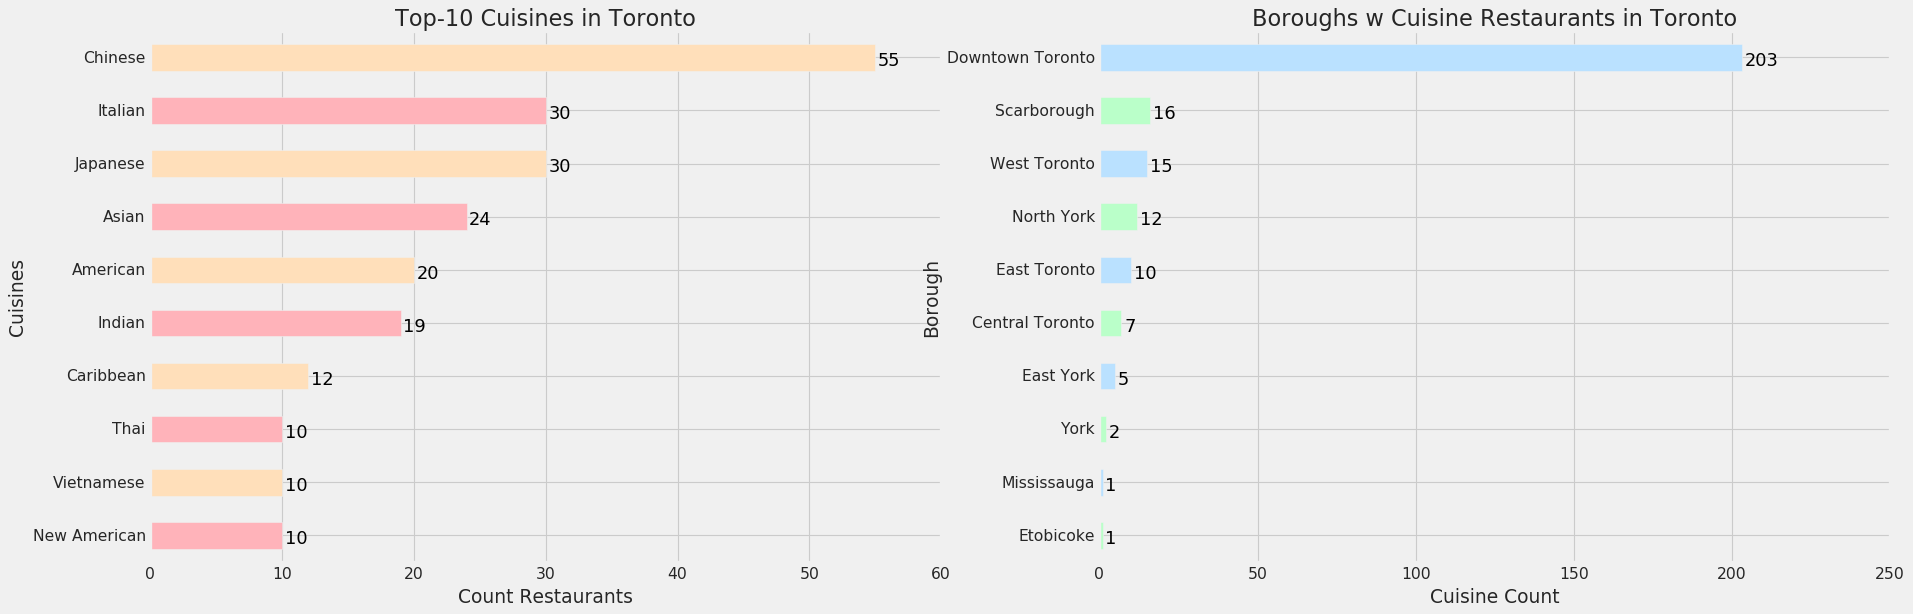

In [25]:
plt.style.use('fivethirtyeight')
colors1=['#ffb3ba','#ffdfba']
colors2=['#baffc9','#bae1ff']
colors=['#ffb3ba','#ffdfba','#ffffba','#baffc9','#bae1ff']

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
cu_top10.plot(kind='barh', figsize=(25,8), color=colors1, ax=ax0) # add to subplot 1
for a in ax0.patches:
    #print(a,' ',str(a.get_y()))
    ax0.annotate(str(a.get_width()),(a.get_width()+0.2,a.get_y()+0.1), color='black',fontsize=16)
ax0.set_xlabel('Count Restaurants')
ax0.set_ylabel('Cuisines')
ax0.set_title('Top-10 Cuisines in Toronto')

# Subplot 2: Line plot
topboroughs.plot(kind='barh', figsize=(25,8), color=colors2, ax=ax1) # add to subplot 2
for a in ax1.patches:
    #print(a,' ',str(a.get_y()))
    ax1.annotate(str(a.get_width()),(a.get_width()+0.9,a.get_y()+0.1), color='black',fontsize=16)
ax1.set_xlabel('Cuisine Count')
ax1.set_ylabel('Borough')
ax1.set_title('Boroughs w Cuisine Restaurants in Toronto')
#ax1.legend([])
#ax1.get_legend().remove()

plt.show()

### 15. But what about all cuisines in Toronto? How much of them are presented? Let's show it on a wafflechart.

In [26]:
cuisines_all=topvenues.reset_index()
#cuisines_all.sort_values(by='Count', ascending=False, inplace=True)
cuisines_all.set_index(['Venue Category'],inplace=True)
cuisines_all.head()

Count
Venue Category       
Mediterranean       1
Ethiopian           1
Deli / Bodega       1
Cuban               1
Hakka               1

In [27]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):
    
    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    #print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
   # for i, tiles in enumerate(tiles_per_category):
   #     print (cuisines_all.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()
    #dark backgr
    #plt.style.use('dark_background')
    #plt.style.use('seaborn-dark-palette')

    # use matshow to display the waffle chart
   # colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    #plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_title('Cuisines Count', fontsize=14)
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    #ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.xticks([])
    plt.yticks([])
   
    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
            #label_str = category 
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            #label_str = category
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        #ncol=len(categories),
        ncol=5,
        bbox_to_anchor=(0.,-1.2,1,0.)
    )

### 16. So, Asian&Chinese are the most popular.

<Figure size 640x480 with 0 Axes>

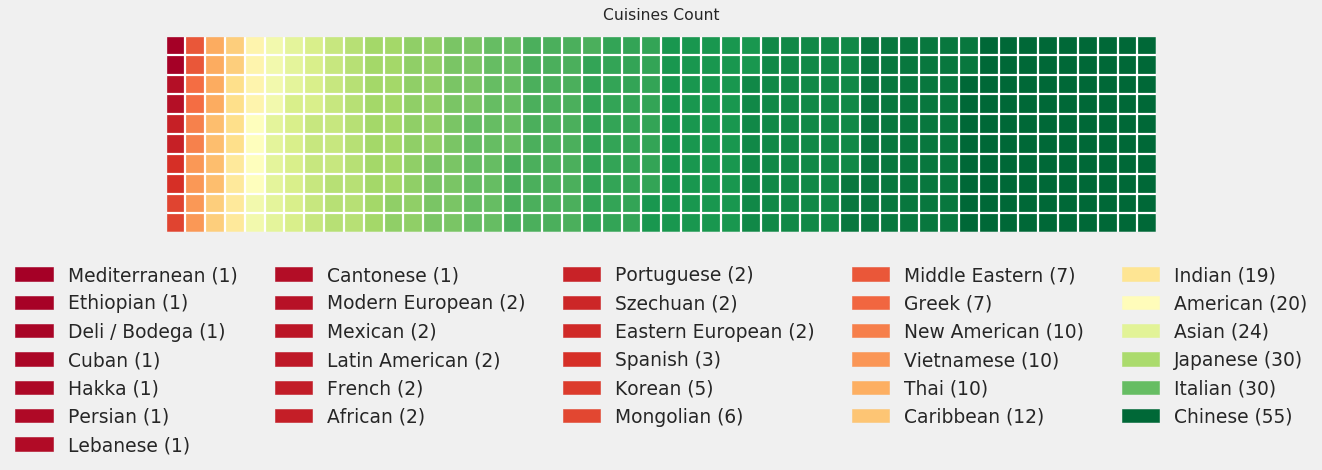

In [28]:
#mpl.cm.get_cmap(name=None, lut=None)
#bbox_to_anchor=(0., -0.2, 0.95, .1)
plt.style.use('fivethirtyeight')
width = 50 # width of chart
height = 10 # height of chart

categories = cuisines_all.index.values # categories
values = cuisines_all['Count'] # correponding values of categories

colormap = plt.cm.RdYlGn # color map class

create_waffle_chart(categories, values, height, width, colormap)

### 17.  I saw that in Downtown Toronto was literally the half of the restaurants, but what about neighborhoods? How cuisines are distributed there? Let's see.

In [29]:
dwtnwn_tor=bn_restaurants.copy()
dwtnwn_tor=dwtnwn_tor[dwtnwn_tor['Venue Category'].isin(cuisines)]
dwtnwn_tor = dwtnwn_tor[dwtnwn_tor['Borough'].str.contains('Downtown Toronto')].reset_index(drop=True)
dwtnwn_tor.head()

FSA           Borough               Neighbourhood  Neighbourhood Latitude  \
0  M4X  Downtown Toronto  Cabbagetown,St. James Town               43.667967   
1  M4X  Downtown Toronto  Cabbagetown,St. James Town               43.667967   
2  M4X  Downtown Toronto  Cabbagetown,St. James Town               43.667967   
3  M4Y  Downtown Toronto        Church and Wellesley               43.665860   
4  M4Y  Downtown Toronto        Church and Wellesley               43.665860   

   Neighbourhood Longitude                     Venue  Venue Latitude  \
0               -79.367675    Tender Trap Restaurant       43.667724   
1               -79.367675        Rainbow Restaurant       43.667416   
2               -79.367675  Athenas Bar & Restaurant       43.664134   
3               -79.383160        Carlton Restaurant       43.661533   
4               -79.383160           Ehwa Restaurant       43.667861   

   Venue Longitude Venue Category  
0       -79.369485        Chinese  
1       -79.369350         Indian  
2       -79.366248          Greek  
3       -79.381012   New American  
4       -79.384884          Asian

In [30]:
dwtnwn_tor_onehot = pd.get_dummies(dwtnwn_tor[['Venue Category']], prefix="", prefix_sep="")
dwtnwn_tor_onehot.head()

African  American  Asian  Cantonese  Caribbean  Chinese  Deli / Bodega  \
0        0         0      0          0          0        1              0   
1        0         0      0          0          0        0              0   
2        0         0      0          0          0        0              0   
3        0         0      0          0          0        0              0   
4        0         0      1          0          0        0              0   

   Ethiopian  French  Greek  Indian  Italian  Japanese  Korean  \
0          0       0      0       0        0         0       0   
1          0       0      0       1        0         0       0   
2          0       0      1       0        0         0       0   
3          0       0      0       0        0         0       0   
4          0       0      0       0        0         0       0   

   Middle Eastern  Modern European  Mongolian  New American  Spanish  \
0               0                0          0             0        0   
1               0                0          0             0        0   
2               0                0          0             0        0   
3               0                0          0             1        0   
4               0                0          0             0        0   

   Szechuan  Thai  Vietnamese  
0         0     0           0  
1         0     0           0  
2         0     0           0  
3         0     0           0  
4         0     0           0

In [31]:
dwtnwn_tor_onehot['Neighbourhood'] = dwtnwn_tor['Neighbourhood'] 
fixed_columns1 = [dwtnwn_tor_onehot.columns[-1]] + list(dwtnwn_tor_onehot.columns[:-1])
dwtnwn_tor_onehot = dwtnwn_tor_onehot[fixed_columns1]
dwtnwn_tor_onehot.head()

Neighbourhood  African  American  Asian  Cantonese  Caribbean  \
0  Cabbagetown,St. James Town        0         0      0          0          0   
1  Cabbagetown,St. James Town        0         0      0          0          0   
2  Cabbagetown,St. James Town        0         0      0          0          0   
3        Church and Wellesley        0         0      0          0          0   
4        Church and Wellesley        0         0      1          0          0   

   Chinese  Deli / Bodega  Ethiopian  French  Greek  Indian  Italian  \
0        1              0          0       0      0       0        0   
1        0              0          0       0      0       1        0   
2        0              0          0       0      1       0        0   
3        0              0          0       0      0       0        0   
4        0              0          0       0      0       0        0   

   Japanese  Korean  Middle Eastern  Modern European  Mongolian  New American  \
0         0       0               0                0          0             0   
1         0       0               0                0          0             0   
2         0       0               0                0          0             0   
3         0       0               0                0          0             1   
4         0       0               0                0          0             0   

   Spanish  Szechuan  Thai  Vietnamese  
0        0         0     0           0  
1        0         0     0           0  
2        0         0     0           0  
3        0         0     0           0  
4        0         0     0           0

### 18. At this time I've got a table with neighborhoods and venues listed. All that should be done is to group the data.

In [32]:
dwtnwn_tor['Venue Category'].unique()

array(['Chinese', 'Indian', 'Greek', 'New American', 'Asian', 'Italian',
       'Thai', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese'], dtype=object)

In [33]:
cuisines_dwntwn=['Chinese', 'Indian', 'Greek', 'New American', 'Asian', 'Thai',
       'Italian', 'Ethiopian', 'African', 'American', 'Caribbean',
       'Japanese', 'Modern European', 'Middle Eastern', 'Spanish',
       'Mongolian', 'Szechuan', 'Vietnamese', 'French', 'Deli / Bodega',
       'Korean', 'Cantonese']

In [34]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts()
dwtnwn_tor_grouped.head()

Neighbourhood           Venue Category
Adelaide,King,Richmond  Chinese           4
                        Indian            3
                        Japanese          3
                        American          2
                        Asian             2
Name: Venue Category, dtype: int64

In [35]:
dwtnwn_tor_grouped = dwtnwn_tor.groupby('Neighbourhood')['Venue Category'].value_counts().unstack().fillna(0).astype(int)
print(dwtnwn_tor_grouped.shape)
#pd.set_option('display.max_columns', None)
dwtnwn_tor_grouped.head()

(16, 22)


Venue Category                           African  American  Asian  Cantonese  \
Neighbourhood                                                                  
Adelaide,King,Richmond                         0         2      2          0   
Berczy Park                                    0         2      0          0   
Cabbagetown,St. James Town                     0         0      0          0   
Central Bay Street                             0         3      1          0   
Chinatown,Grange Park,Kensington Market        0         0      3          1   

Venue Category                           Caribbean  Chinese  Deli / Bodega  \
Neighbourhood                                                                
Adelaide,King,Richmond                           2        4              0   
Berczy Park                                      0        0              0   
Cabbagetown,St. James Town                       0        1              0   
Central Bay Street                               1       10              0   
Chinatown,Grange Park,Kensington Market          1       19              0   

Venue Category                           Ethiopian  French  Greek  Indian  \
Neighbourhood                                                               
Adelaide,King,Richmond                           0       0      1       3   
Berczy Park                                      0       0      0       0   
Cabbagetown,St. James Town                       0       0      1       1   
Central Bay Street                               0       1      0       1   
Chinatown,Grange Park,Kensington Market          0       0      0       0   

Venue Category                           Italian  Japanese  Korean  \
Neighbourhood                                                        
Adelaide,King,Richmond                         2         3       0   
Berczy Park                                    0         1       0   
Cabbagetown,St. James Town                     0         0       0   
Central Bay Street                             2         2       0   
Chinatown,Grange Park,Kensington Market        0         0       3   

Venue Category                           Middle Eastern  Modern European  \
Neighbourhood                                                              
Adelaide,King,Richmond                                1                0   
Berczy Park                                           0                0   
Cabbagetown,St. James Town                            0                0   
Central Bay Street                                    2                1   
Chinatown,Grange Park,Kensington Market               0                0   

Venue Category                           Mongolian  New American  Spanish  \
Neighbourhood                                                               
Adelaide,King,Richmond                           0             1        0   
Berczy Park                                      1             0        0   
Cabbagetown,St. James Town                       0             0        0   
Central Bay Street                               0             0        0   
Chinatown,Grange Park,Kensington Market          0             0        0   

Venue Category                           Szechuan  Thai  Vietnamese  
Neighbourhood                                                        
Adelaide,King,Richmond                          0     0           1  
Berczy Park                                     0     0           0  
Cabbagetown,St. James Town                      0     0           0  
Central Bay Street                              2     1           1  
Chinatown,Grange Park,Kensington Market         0     0           5

### 19.  But the pivot table is not so handy to visualize. Let's turn it into a regular DF.

In [36]:
flattened = pd.DataFrame(dwtnwn_tor_grouped.to_records())
flattened['Total']=flattened.sum(axis=1)
flattened.sort_values(by='Total', ascending=True, inplace=True)
flattened.drop(['Total'], axis=1, inplace=True)
flattened=flattened.set_index('Neighbourhood')
flattened=flattened.append(flattened.sum().rename('Total'))
flattened.sort_values(by='Total', axis=1, ascending=False, inplace=True)
flattened.drop(['Total'], axis=0, inplace=True)
flattened.tail()

Chinese  Japanese  Italian  Asian  \
Neighbourhood                                                                
Commerce Court,Victoria Hotel                  0         4        3      1   
Adelaide,King,Richmond                         4         3        2      2   
Ryerson,Garden District                        4         2        3      4   
Central Bay Street                            10         2        2      1   
Chinatown,Grange Park,Kensington Market       19         0        0      3   

                                         American  Indian  Caribbean  \
Neighbourhood                                                          
Commerce Court,Victoria Hotel                   2       2          1   
Adelaide,King,Richmond                          2       3          2   
Ryerson,Garden District                         3       1          1   
Central Bay Street                              3       1          1   
Chinatown,Grange Park,Kensington Market         0       0          1   

                                         New American  Thai  Vietnamese  \
Neighbourhood                                                             
Commerce Court,Victoria Hotel                       1     1           0   
Adelaide,King,Richmond                              1     0           1   
Ryerson,Garden District                             1     3           0   
Central Bay Street                                  0     1           1   
Chinatown,Grange Park,Kensington Market             0     0           5   

                                         Mongolian  Greek  Middle Eastern  \
Neighbourhood                                                               
Commerce Court,Victoria Hotel                    1      0               0   
Adelaide,King,Richmond                           0      1               1   
Ryerson,Garden District                          0      0               1   
Central Bay Street                               0      0               2   
Chinatown,Grange Park,Kensington Market          0      0               0   

                                         Korean  Spanish  Modern European  \
Neighbourhood                                                               
Commerce Court,Victoria Hotel                 0        1                0   
Adelaide,King,Richmond                        0        0                0   
Ryerson,Garden District                       0        0                1   
Central Bay Street                            0        0                1   
Chinatown,Grange Park,Kensington Market       3        0                0   

                                         Szechuan  French  Ethiopian  \
Neighbourhood                                                          
Commerce Court,Victoria Hotel                   0       0          0   
Adelaide,King,Richmond                          0       0          0   
Ryerson,Garden District                         0       0          0   
Central Bay Street                              2       1          0   
Chinatown,Grange Park,Kensington Market         0       0          0   

                                         Deli / Bodega  Cantonese  African  
Neighbourhood                                                               
Commerce Court,Victoria Hotel                        0          0        0  
Adelaide,King,Richmond                               0          0        0  
Ryerson,Garden District                              0          0        0  
Central Bay Street                                   0          0        0  
Chinatown,Grange Park,Kensington Market              0          1        0

### 20. That's better. Now I could present the data in barh plot. And chinese cuisine is the winner once more!

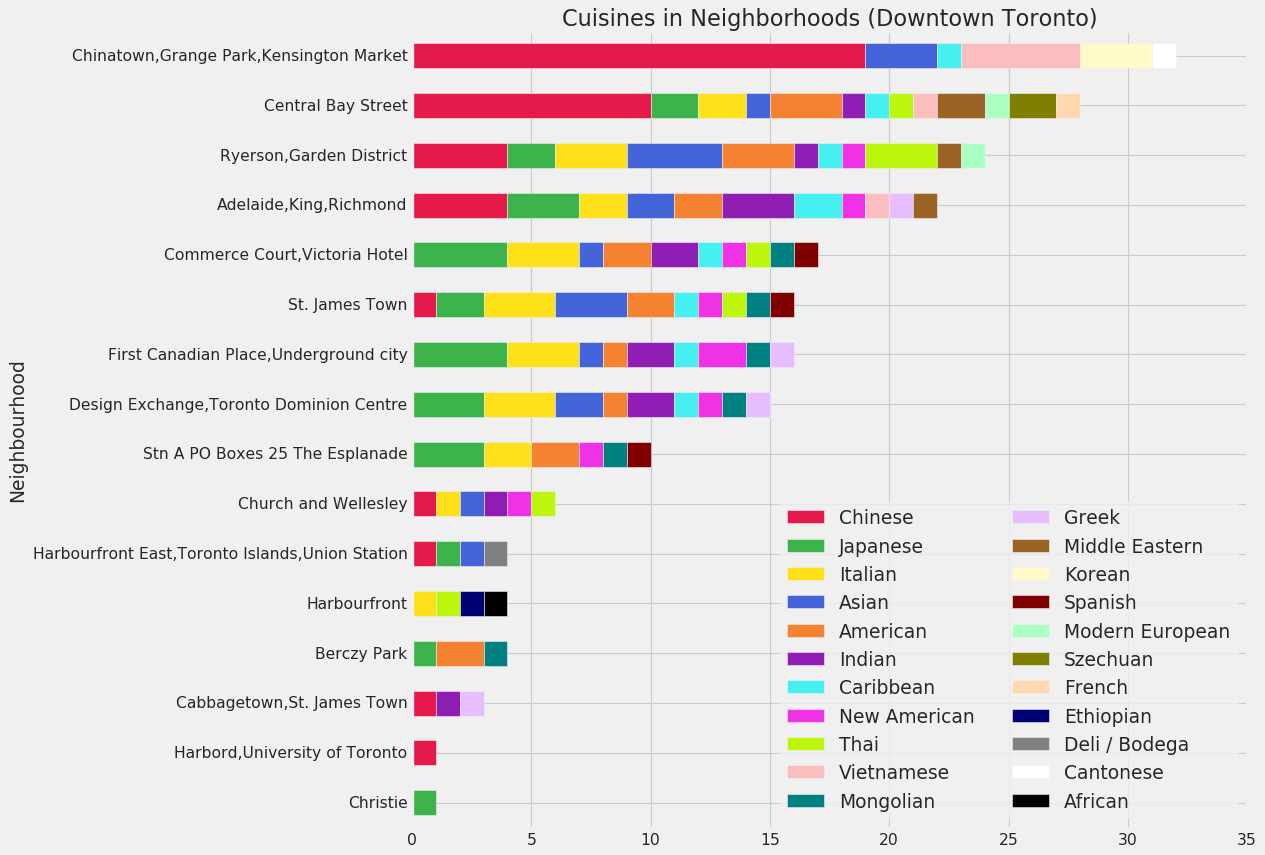

In [37]:
distinctcolors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
              '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
              '#000075', '#808080', '#ffffff', '#000000']

pastelcolors=['#FEADCD','#fe69af','#7AE7B9','#5BD2F0','#9BE7FF','#B9ACF2',
              '#67D0DD','#9FE481','#FEE287','#FAAFA5','#DC95DD','#A885EE',
              '#CD0161','#FD6966','#b7de0f','#79DC78','#FFB449','#F89246',]

ax=flattened.plot.barh(stacked=True,figsize=(12,12),color=distinctcolors);
#for a in ax.patches:
#    if a.get_width() != 0:
#        ax.annotate(str(a.get_width()),(a.get_x()+a.get_width()/2,a.get_y()+0.2), color='white',fontsize=10,ha="center", va="center",fontweight="bold")
ax.set_title('Cuisines in Neighborhoods (Downtown Toronto)')
ax.legend(loc='best',ncol=2,frameon=True,framealpha=0.8)

In [38]:
handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)

[<BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>, <BarContainer object of 16 artists>]
['Chinese', 'Japanese', 'Italian', 'Asian', 'American', 'Indian', 'Caribbean', 'New American', 'Thai', 'Vietnamese', 'Mongolian', 'Greek', 'Middle Eastern', 'Korean', 'Spanish', 'Modern

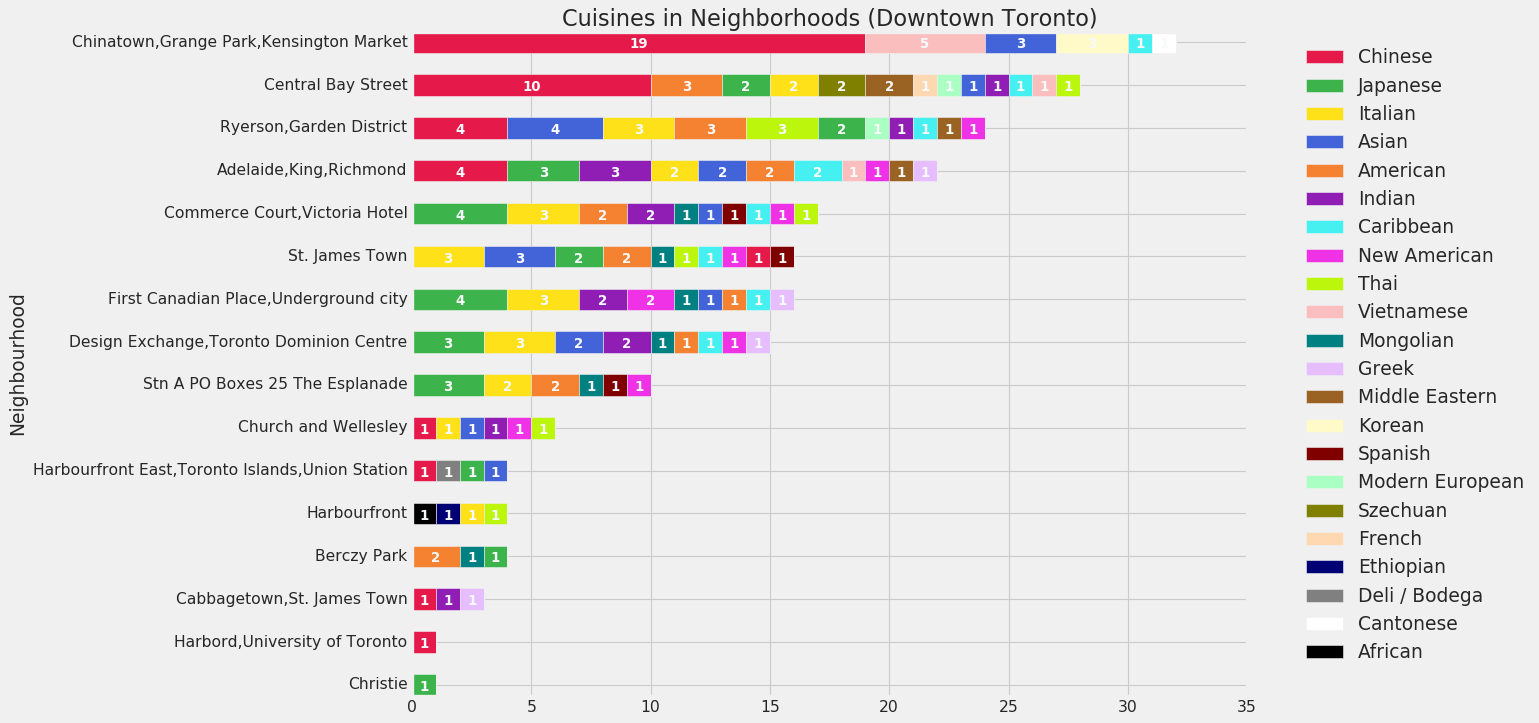

In [39]:
fig, ax = plt.subplots(figsize=(12,10))
x = flattened.index

indexes = np.argsort(flattened.values).T
widths = np.sort(flattened.values).T
order = -1
lefts = widths[::order].cumsum(axis=0)
lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

mpp_colors = dict(zip(flattened.columns, distinctcolors))

for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
    mps = np.take(np.array(flattened.columns), idxs)
    ax.barh(x, width=vals, height=0.5, left=lefts[k], color=[mpp_colors[m] for m in mps])

for a in ax.patches:
    if a.get_width() != 0:
        ax.annotate(str(a.get_width()),(a.get_x()+a.get_width()/2,a.get_y()+0.2), color='#f7f9fa',fontsize=12,ha="center", va="center",fontweight="bold")
ax.set_title('Cuisines in Neighborhoods (Downtown Toronto)')    
ax.set_ylabel('Neighbourhood')

#ax.legend((np.take(np.array(flattened.columns), np.argsort(flattened.values)[0]))[::order], bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
#ax.legend((np.array(flattened.columns)), bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.legend(handles[::-order],(np.array(flattened.columns))[::-order], bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

### 21. Now for the science part. I thought that it may be useful to cluster boroughs by the type of the cuisine in restaurants they have.
### At first, we've got to list all kinds of them in one table.

In [40]:
topneighs=bn_restaurants.copy().reset_index()
topneighs=topneighs[topneighs['Venue Category'].isin(cuisines)]
topneighs_onehot = pd.get_dummies(topneighs[['Venue Category']], prefix="", prefix_sep="")
topneighs_onehot['Borough'] = topneighs['Borough'] 
fixed_columns = [topneighs_onehot.columns[-1]] + list(topneighs_onehot.columns[:-1])
topneighs_onehot = topneighs_onehot[fixed_columns]
topneighs_onehot.head()

Borough  African  American  Asian  Cantonese  Caribbean  Chinese  \
0  Scarborough        0         0      0          0          0        0   
2  Scarborough        0         0      0          0          0        0   
3  Scarborough        0         0      0          0          0        0   
4  Scarborough        0         0      0          0          0        0   
5  Scarborough        0         0      0          0          0        1   

   Cuban  Deli / Bodega  Eastern European  Ethiopian  French  Greek  Hakka  \
0      0              0                 0          0       0      0      1   
2      0              0                 0          0       0      0      0   
3      0              0                 0          0       0      0      0   
4      0              0                 0          0       0      0      0   
5      0              0                 0          0       0      0      0   

   Indian  Italian  Japanese  Korean  Latin American  Lebanese  Mediterranean  \
0       0        0         0       0               0         0              0   
2       0        1         0       0               0         0              0   
3       0        0         0       0               0         0              0   
4       1        0         0       0               0         0              0   
5       0        0         0       0               0         0              0   

   Mexican  Middle Eastern  Modern European  Mongolian  New American  Persian  \
0        0               0                0          0             0        0   
2        0               0                0          0             0        0   
3        0               0                0          0             0        0   
4        0               0                0          0             0        0   
5        0               0                0          0             0        0   

   Portuguese  Spanish  Szechuan  Thai  Vietnamese  
0           0        0         0     0           0  
2           0        0         0     0           0  
3           0        0         0     1           0  
4           0        0         0     0           0  
5           0        0         0     0           0

### 22. Second, group them to show the mean value for every venue.

In [41]:
topneighs_grouped = topneighs_onehot.groupby('Borough').mean().reset_index()
topneighs_grouped

Borough   African  American     Asian  Cantonese  Caribbean  \
0   Central Toronto  0.000000  0.000000  0.142857   0.000000   0.000000   
1  Downtown Toronto  0.004926  0.088670  0.093596   0.004926   0.044335   
2      East Toronto  0.000000  0.000000  0.100000   0.000000   0.100000   
3         East York  0.200000  0.200000  0.000000   0.000000   0.200000   
4         Etobicoke  0.000000  0.000000  0.000000   0.000000   0.000000   
5       Mississauga  0.000000  0.000000  0.000000   0.000000   0.000000   
6        North York  0.000000  0.000000  0.166667   0.000000   0.000000   
7       Scarborough  0.000000  0.000000  0.000000   0.000000   0.000000   
8      West Toronto  0.000000  0.066667  0.066667   0.000000   0.000000   
9              York  0.000000  0.000000  0.000000   0.000000   0.500000   

    Chinese     Cuban  Deli / Bodega  Eastern European  Ethiopian    French  \
0  0.142857  0.000000       0.000000          0.142857   0.000000  0.000000   
1  0.206897  0.000000       0.004926          0.000000   0.004926  0.004926   
2  0.000000  0.000000       0.000000          0.000000   0.000000  0.000000   
3  0.000000  0.000000       0.000000          0.000000   0.000000  0.000000   
4  0.000000  0.000000       0.000000          0.000000   0.000000  0.000000   
5  1.000000  0.000000       0.000000          0.000000   0.000000  0.000000   
6  0.083333  0.000000       0.000000          0.083333   0.000000  0.000000   
7  0.562500  0.000000       0.000000          0.000000   0.000000  0.000000   
8  0.000000  0.066667       0.000000          0.000000   0.000000  0.066667   
9  0.500000  0.000000       0.000000          0.000000   0.000000  0.000000   

      Greek   Hakka    Indian   Italian  Japanese    Korean  Latin American  \
0  0.000000  0.0000  0.142857  0.285714  0.000000  0.000000        0.000000   
1  0.019704  0.0000  0.064039  0.113300  0.128079  0.014778        0.000000   
2  0.300000  0.0000  0.100000  0.100000  0.000000  0.000000        0.000000   
3  0.000000  0.0000  0.200000  0.000000  0.000000  0.000000        0.000000   
4  0.000000  0.0000  0.000000  0.000000  0.000000  1.000000        0.000000   
5  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000        0.000000   
6  0.000000  0.0000  0.083333  0.166667  0.250000  0.000000        0.000000   
7  0.000000  0.0625  0.125000  0.062500  0.000000  0.062500        0.000000   
8  0.000000  0.0000  0.000000  0.066667  0.066667  0.000000        0.133333   
9  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000        0.000000   

   Lebanese  Mediterranean   Mexican  Middle Eastern  Modern European  \
0       0.0            0.0  0.000000        0.000000         0.000000   
1       0.0            0.0  0.000000        0.019704         0.009852   
2       0.1            0.1  0.000000        0.000000         0.000000   
3       0.0            0.0  0.000000        0.200000         0.000000   
4       0.0            0.0  0.000000        0.000000         0.000000   
5       0.0            0.0  0.000000        0.000000         0.000000   
6       0.0            0.0  0.000000        0.083333         0.000000   
7       0.0            0.0  0.000000        0.062500         0.000000   
8       0.0            0.0  0.133333        0.000000         0.000000   
9       0.0            0.0  0.000000        0.000000         0.000000   

   Mongolian  New American  Persian  Portuguese   Spanish  Szechuan      Thai  \
0   0.000000      0.000000      0.0    0.000000  0.000000  0.000000  0.142857   
1   0.029557      0.044335      0.0    0.000000  0.014778  0.009852  0.039409   
2   0.000000      0.000000      0.1    0.000000  0.000000  0.000000  0.000000   
3   0.000000      0.000000      0.0    0.000000  0.000000  0.000000  0.000000   
4   0.000000      0.000000      0.0    0.000000  0.000000  0.000000  0.000000   
5   0.000000      0.000000      0.0    0.000000  0.000000  0.000000  0.000000   
6   0.000000      0.000000      0.0    0.000000  0.000000  0.000000  0.0000

### 23. And third, gather the most common 5 venues for each neighborhood.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = topneighs_grouped['Borough']

for ind in np.arange(topneighs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(topneighs_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Borough 1st Most Common Venue 2nd Most Common Venue  \
0   Central Toronto               Italian                 Asian   
1  Downtown Toronto               Chinese              Japanese   
2      East Toronto                 Greek                Indian   
3         East York               African              American   
4         Etobicoke                Korean            Vietnamese   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0               Chinese      Eastern European                Indian  
1               Italian                 Asian              American  
2         Mediterranean               Italian                 Asian  
3             Caribbean        Middle Eastern                Indian  
4               Italian              American                 Asian

### 24. To apply the kNN method we should calculate the K value first. For that I use common scikit functions to fit the model and then calculate squared error. Yellowbrick could help to visualize all process and say what K value should be used.

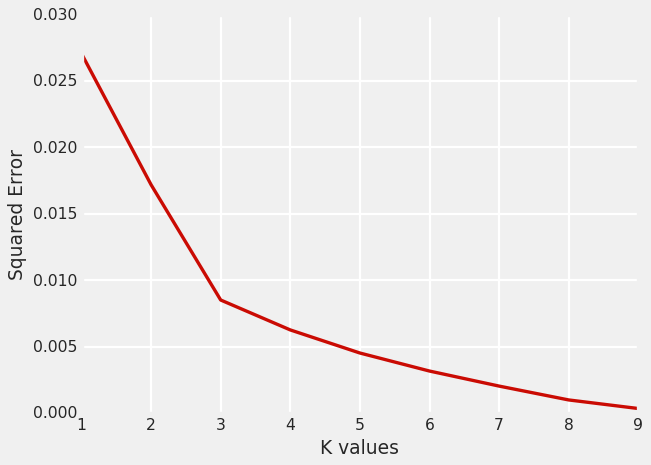

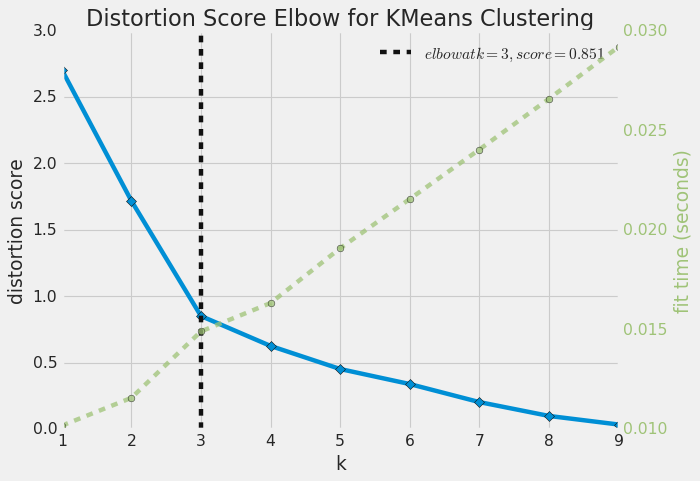

In [44]:
neighborhoods_clustering=topneighs_grouped.drop('Borough',1)


error_cost=[]

for i in range(1,10):
    KM=KMeans(n_clusters=i,max_iter=100)
    KM.fit(neighborhoods_clustering)
    error_cost.append(KM.inertia_/100)
    
plt.plot(range(1,10),error_cost,color='r',linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error')
plt.grid(color='white',linestyle='-',linewidth=2)
plt.show()


model=KMeans()
visualizer=KElbowVisualizer(model,k=(1,10))
visualizer.fit(neighborhoods_clustering)
visualizer.show()

### 25. Here it is! K=3. Let's add cluster labels to our data frame.

In [45]:
# set number of clusters
kclusters = 3
topneighs_grouped_clustering = topneighs_grouped.drop('Borough', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(topneighs_grouped_clustering)
kmeans.labels_[0:10]

array([1, 1, 1, 1, 2, 0, 1, 0, 1, 0], dtype=int32)

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
topneighs_merged = toronto_all
topneighs_merged = topneighs_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')
topneighs_merged.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353             0.0               Chinese                Indian   
1 -79.160497             0.0               Chinese                Indian   
2 -79.188711             0.0               Chinese                Indian   
3 -79.216917             0.0               Chinese                Indian   
4 -79.239476             0.0               Chinese                Indian   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0               Italian                  Thai                Korean  
1               Italian                  Thai                Korean  
2               Italian                  Thai                Korean  
3               Italian                  Thai                Korean  
4               Italian                  Thai                Korean

In [47]:
topneighs_merged=topneighs_merged.dropna()
topneighs_merged.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353             0.0               Chinese                Indian   
1 -79.160497             0.0               Chinese                Indian   
2 -79.188711             0.0               Chinese                Indian   
3 -79.216917             0.0               Chinese                Indian   
4 -79.239476             0.0               Chinese                Indian   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0               Italian                  Thai                Korean  
1               Italian                  Thai                Korean  
2               Italian                  Thai                Korean  
3               Italian                  Thai                Korean  
4               Italian                  Thai                Korean

### 26. The final result with labels is here, now we could add it to the map.

In [48]:
topneighs_merged['Cluster Labels'] = topneighs_merged['Cluster Labels'].astype(int)
topneighs_merged.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353               0               Chinese                Indian   
1 -79.160497               0               Chinese                Indian   
2 -79.188711               0               Chinese                Indian   
3 -79.216917               0               Chinese                Indian   
4 -79.239476               0               Chinese                Indian   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0               Italian                  Thai                Korean  
1               Italian                  Thai                Korean  
2               Italian                  Thai                Korean  
3               Italian                  Thai                Korean  
4               Italian                  Thai                Korean

In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors

#‘OpenStreetMap’, ‘cartodbpositron’, ‘cartodbdark_matter’

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='cartodbdark_matter')
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Set3(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(topneighs_merged['Latitude'], topneighs_merged['Longitude'], topneighs_merged['Neighbourhood'], topneighs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 27. I explored each cluster to see how are the boroughs grouped.

In [50]:
cls=topneighs_merged.copy()
cls.drop(['Postcode','Borough','Longitude','Latitude','Neighbourhood'],axis=1,inplace=True)
cls.sort_values(by='Cluster Labels', ascending=True, inplace=True)
columns_raitings=['1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']
header_list_all=np.unique(cls[columns_raitings].values)

In [51]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 0, topneighs_merged.columns[[2] + list(range(5, topneighs_merged.shape[1]))]]

Neighbourhood  Cluster Labels  \
0                                       Rouge,Malvern               0   
1                Highland Creek,Rouge Hill,Port Union               0   
2                     Guildwood,Morningside,West Hill               0   
3                                              Woburn               0   
4                                           Cedarbrae               0   
5                                 Scarborough Village               0   
6           East Birchmount Park,Ionview,Kennedy Park               0   
7                       Clairlea,Golden Mile,Oakridge               0   
8       Cliffcrest,Cliffside,Scarborough Village West               0   
9                          Birch Cliff,Cliffside West               0   
10  Dorset Park,Scarborough Town Centre,Wexford He...               0   
11                                   Maryvale,Wexford               0   
12                                          Agincourt               0   
13              Clarks Corners,Sullivan,Tam O'Shanter               0   
14  Agincourt North,L'Amoreaux East,Milliken,Steel...               0   
15                                    L'Amoreaux West               0   
16                                        Upper Rouge               0   
73                                 Humewood-Cedarvale               0   
74                                Caledonia-Fairbanks               0   
80        Del Ray,Keelesdale,Mount Dennis,Silverthorn               0   
81                       The Junction North,Runnymede               0   
86              Canada Post Gateway Processing Centre               0   
98                                             Weston               0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                Chinese                Indian               Italian   
1                Chinese                Indian               Italian   
2                Chinese                Indian               Italian   
3                Chinese                Indian               Italian   
4                Chinese                Indian               Italian   
5                Chinese                Indian               Italian   
6                Chinese                Indian               Italian   
7                Chinese                Indian               Italian   
8                Chinese                Indian               Italian   
9                Chinese                Indian               Italian   
10               Chinese                Indian               Italian   
11               Chinese                Indian               Italian   
12               Chinese                Indian               Italian   
13               Chinese                Indian               Italian   
14               Chinese                Indian               Italian   
15               Chinese                Indian               Italian   
16               Chinese                Indian               Italian   
73             Caribbean               Chinese            Vietnamese   
74             Caribbean               Chinese            Vietnamese   
80             Caribbean               Chinese            Vietnamese   
81             Caribbean               Chinese            Vietnamese   
86               Chinese            Vietnamese               Italian   
98             Caribbean               Chinese            Vietnamese   

   4th Most Common Venue 5th Most Common Venue  
0                   Thai                Korean  
1                   Thai                Korean  
2                   Thai                Korean  
3                   Thai                Korean  
4                   Thai                Korean  
5                   Thai                Korean  
6                   Thai                Korean  
7                   Thai                Korean  
8                   Thai                Korean  
9                   Thai                Korean  
10                 

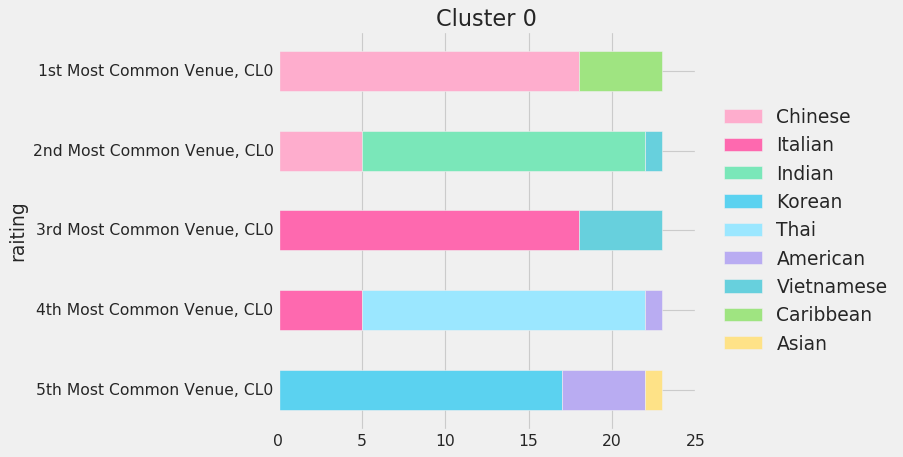

In [52]:
CL0=cls.loc[cls['Cluster Labels']==0]
#x0=x0.set_index('Cluster Labels')CL0.drop(['Cluster Labels'],axis=1,inplace=True)
header_list0=np.unique(CL0[columns_raitings].values)

clust0_df=pd.DataFrame()

for ind in reversed(np.arange(num_top_venues)):
    clust_df=CL0.loc[:,columns_raitings[ind]]
    clust_df=pd.get_dummies(clust_df)
    clust_df=clust_df.sum(axis=0)
    clust_df=clust_df.to_frame()
    clust_df=clust_df.transpose()
    clust_df = clust_df.reindex(columns = header_list0)
    clust_df['raiting']=columns_raitings[ind]+', CL0'
    clust_df=clust_df.set_index('raiting')
    clust_df=clust_df.fillna(0).astype(int)
    clust0_df=clust0_df.append(clust_df)
    
#clust0_df

clust0_df=clust0_df.append(clust0_df.sum().rename('Total'))
clust0_df.sort_values(by='Total', axis=1, ascending=False, inplace=True)
clust0_df.drop(['Total'], axis=0, inplace=True)

ax=clust0_df.plot.barh(stacked=True,figsize=(6,6),color=pastelcolors);
ax.set_title('Cluster 0')
ax.legend(loc='center right',ncol=1,frameon=True,framealpha=0.8,bbox_to_anchor=(1.5, 0.5))

In [53]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 1, topneighs_merged.columns[[2] + list(range(5, topneighs_merged.shape[1]))]]

Neighbourhood  Cluster Labels  \
17                                  Hillcrest Village               1   
18                         Fairview,Henry Farm,Oriole               1   
19                                    Bayview Village               1   
20                            Silver Hills,York Mills               1   
21                             Newtonbrook,Willowdale               1   
22                                   Willowdale South               1   
23                                    York Mills West               1   
24                                    Willowdale West               1   
25                                          Parkwoods               1   
26                                    Don Mills North               1   
27                    Flemingdon Park,Don Mills South               1   
28      Bathurst Manor,Downsview North,Wilson Heights               1   
29                     Northwood Park,York University               1   
30                         CFB Toronto,Downsview East               1   
31                                     Downsview West               1   
32                                  Downsview Central               1   
33                                Downsview Northwest               1   
34                                   Victoria Village               1   
35                     Woodbine Gardens,Parkview Hill               1   
36                                   Woodbine Heights               1   
37                                        The Beaches               1   
38                                            Leaside               1   
39                                   Thorncliffe Park               1   
40                                       East Toronto               1   
41                        The Danforth West,Riverdale               1   
42                      The Beaches West,India Bazaar               1   
43                                    Studio District               1   
44                                      Lawrence Park               1   
45                                   Davisville North               1   
46                                 North Toronto West               1   
47                                         Davisville               1   
48                         Moore Park,Summerhill East               1   
49  Deer Park,Forest Hill SE,Rathnelly,South Hill,...               1   
50                                           Rosedale               1   
51                         Cabbagetown,St. James Town               1   
52                               Church and Wellesley               1   
53                                       Harbourfront               1   
54                            Ryerson,Garden District               1   
55                                     St. James Town               1   
56                                        Berczy Park               1   
57                                 Central Bay Street               1   
58                             Adelaide,King,Richmond               1   
59    Harbourfront East,Toronto Islands,Union Station               1   
60            Design Exchange,Toronto Dominion Centre               1   
61                      Commerce Court,Victoria Hotel               1   
62                   Bedford Park,Lawrence Manor East               1   
63                                           Roselawn               1   
64                 Forest Hill North,Forest Hill West               1   
65                  The Annex,North Midtown,Yorkville               1   
66                      Harbord,University of Toronto               1   
67            Chinatown,Grange Park,Kensington Market               1   
68  CN Tower,Bathurst Quay,Island airport,Harbourf...               1   
69                    Stn A PO Boxes 25 The Esplanade               1   
70              First Canadian Place,Underground city               1   
71                    Law

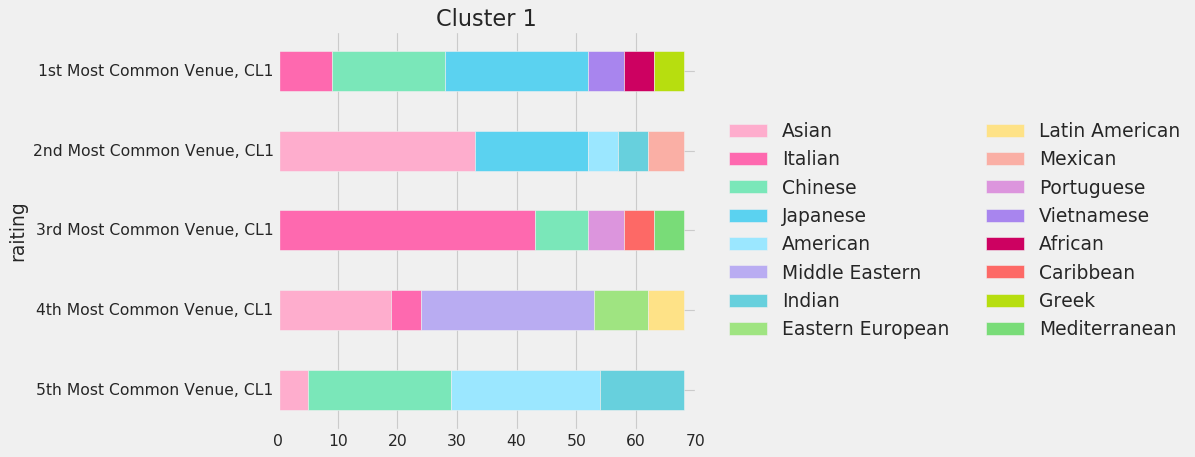

In [54]:
CL1=cls.loc[cls['Cluster Labels']==1]
#x0=x0.set_index('Cluster Labels')CL0.drop(['Cluster Labels'],axis=1,inplace=True)
columns_raitings=['1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']
header_list1=np.unique(CL1[columns_raitings].values)


clust1_df=pd.DataFrame()

for ind in reversed(np.arange(num_top_venues)):
    clust_df=CL1.loc[:,columns_raitings[ind]]
    clust_df=pd.get_dummies(clust_df)
    clust_df=clust_df.sum(axis=0)
    clust_df=clust_df.to_frame()
    clust_df=clust_df.transpose()
    clust_df = clust_df.reindex(columns = header_list1)
    clust_df['raiting']=columns_raitings[ind]+', CL1'
    clust_df=clust_df.set_index('raiting')
    clust_df=clust_df.fillna(0).astype(int)
    clust1_df=clust1_df.append(clust_df)
    
#clust1_df

clust1_df=clust1_df.append(clust1_df.sum().rename('Total'))
clust1_df.sort_values(by='Total', axis=1, ascending=False, inplace=True)
clust1_df.drop(['Total'], axis=0, inplace=True)

ax=clust1_df.plot.barh(stacked=True,figsize=(6,6),color=pastelcolors);
ax.set_title('Cluster 1')
ax.legend(loc='center right',ncol=2,frameon=True,framealpha=0.8,bbox_to_anchor=(2.2, 0.5))

In [55]:
topneighs_merged.loc[topneighs_merged['Cluster Labels'] == 2, topneighs_merged.columns[[2] + list(range(5, topneighs_merged.shape[1]))]]

Neighbourhood  Cluster Labels  \
88          Humber Bay Shores,Mimico South,New Toronto               2   
89                               Alderwood,Long Branch               2   
90         The Kingsway,Montgomery Road,Old Mill North               2   
91   Humber Bay,King's Mill Park,Kingsway Park Sout...               2   
92   Kingsway Park South West,Mimico NW,The Queensw...               2   
94   Cloverdale,Islington,Martin Grove,Princess Gar...               2   
95   Bloordale Gardens,Eringate,Markland Wood,Old B...               2   
99                                           Westmount               2   
100  Kingsview Village,Martin Grove Gardens,Richvie...               2   
101  Albion Gardens,Beaumond Heights,Humbergate,Jam...               2   
102                                          Northwest               2   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
88                 Korean            Vietnamese               Italian   
89                 Korean            Vietnamese               Italian   
90                 Korean            Vietnamese               Italian   
91                 Korean            Vietnamese               Italian   
92                 Korean            Vietnamese               Italian   
94                 Korean            Vietnamese               Italian   
95                 Korean            Vietnamese               Italian   
99                 Korean            Vietnamese               Italian   
100                Korean            Vietnamese               Italian   
101                Korean            Vietnamese               Italian   
102                Korean            Vietnamese               Italian   

    4th Most Common Venue 5th Most Common Venue  
88               American                 Asian  
89               American                 Asian  
90               American                 Asian  
91               American                 Asian  
92               American                 Asian  
94               American                 Asian  
95               American                 Asian  
99               American                 Asian  
100              American                 Asian  
101              American                 Asian  
102              American                 Asian

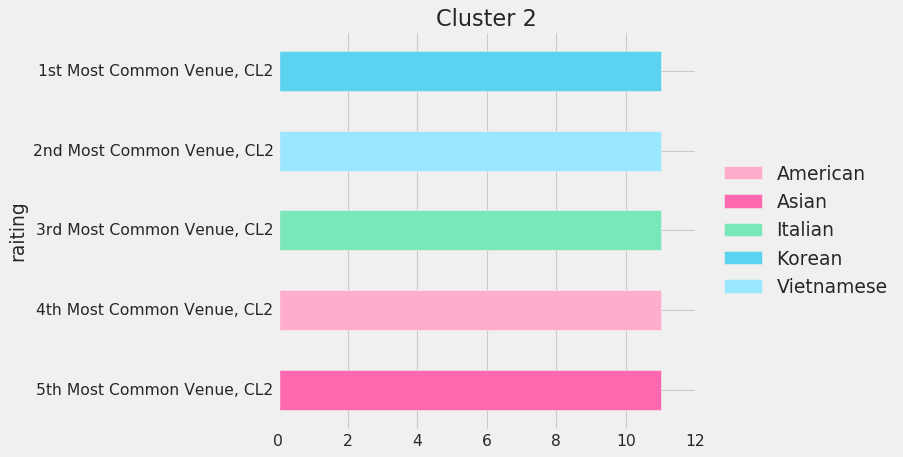

In [56]:
CL2=cls.loc[cls['Cluster Labels']==2]
#x0=x0.set_index('Cluster Labels')CL0.drop(['Cluster Labels'],axis=1,inplace=True)
columns_raitings=['1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']
header_list2=np.unique(CL2[columns_raitings].values)


clust2_df=pd.DataFrame()

for ind in reversed(np.arange(num_top_venues)):
    clust_df=CL2.loc[:,columns_raitings[ind]]
    clust_df=pd.get_dummies(clust_df)
    clust_df=clust_df.sum(axis=0)
    clust_df=clust_df.to_frame()
    clust_df=clust_df.transpose()
    clust_df = clust_df.reindex(columns = header_list2)
    clust_df['raiting']=columns_raitings[ind]+', CL2'
    clust_df=clust_df.set_index('raiting')
    clust_df=clust_df.fillna(0).astype(int)
    clust2_df=clust2_df.append(clust_df)
    
#clust2_df

clust2_df=clust2_df.append(clust2_df.sum().rename('Total'))
clust2_df.sort_values(by='Total', axis=1, ascending=False, inplace=True)
clust2_df.drop(['Total'], axis=0, inplace=True)

ax=clust2_df.plot.barh(stacked=True,figsize=(6,6),color=pastelcolors);
ax.set_title('Cluster 2')
ax.legend(loc='center right',ncol=1,frameon=True,framealpha=0.8,bbox_to_anchor=(1.5, 0.5))

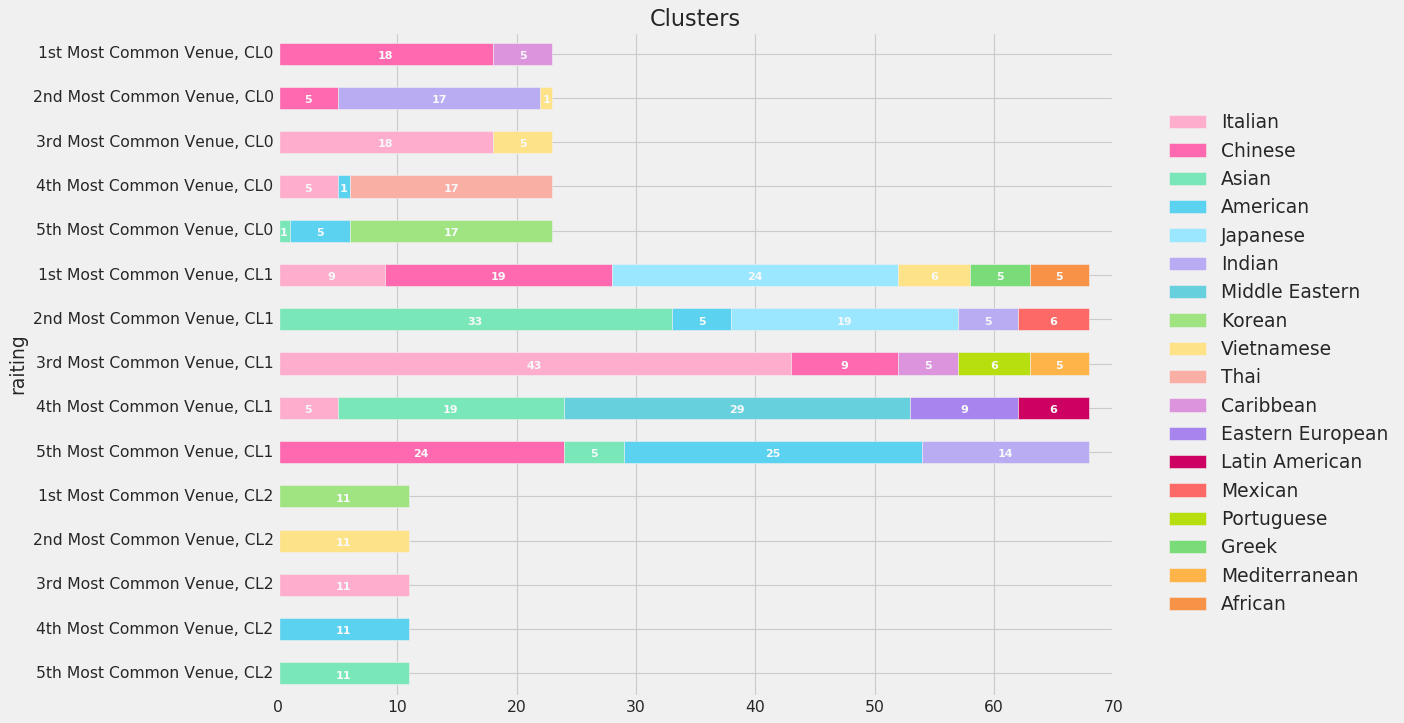

In [57]:
#x_all=pd.concat([clust2_df,clust1_df,clust0_df])

diffs0 = list(set(header_list_all) - set(header_list0))
clust0_df = clust0_df.reindex(columns = clust0_df.columns.tolist() + diffs0)
clust0_df=clust0_df.fillna(0).astype(int)
clust0_df

diffs1 = list(set(header_list_all) - set(header_list1))
clust1_df = clust1_df.reindex(columns = clust1_df.columns.tolist() + diffs1)
clust1_df=clust1_df.fillna(0).astype(int)
clust1_df

diffs2 = list(set(header_list_all) - set(header_list2))
clust2_df = clust2_df.reindex(columns = clust2_df.columns.tolist() + diffs2)
clust2_df=clust2_df.fillna(0).astype(int)
clust2_df

x_all=pd.concat([clust2_df,clust1_df,clust0_df],sort=True)

#x_all
#x_all2=[clust2_df,clust1_df,clust0_df]
#x_all2[0]

x_all=x_all.append(x_all.sum().rename('Total'))
x_all.sort_values(by='Total', axis=1, ascending=False, inplace=True)
x_all.drop(['Total'], axis=0, inplace=True)


ax=x_all.plot.barh(stacked=True,figsize=(12,10),color=pastelcolors);
ax.set_title('Clusters')
for a in ax.patches:
    #print(a,' ',str(a.get_y()))
    if a.get_width() != 0:
        ax.annotate(str(a.get_width()),(a.get_x()+a.get_width()/2,a.get_y()+0.2), color='#f7f9fa',fontsize=10,ha="center", va="center",fontweight="bold")
ax.legend(loc='center right',ncol=1,frameon=True,framealpha=0.8,bbox_to_anchor=(1.35, 0.5))#

In [58]:
handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)

[<BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>, <BarContainer object of 15 artists>]
['Italian', 'Chinese', 'Asian', 'American', 'Japanese', 'Indian', 'Middle Eastern', 'Korean', 'Vietnamese', 'Thai', 'Caribbean', 'Eastern European', 'Latin American', 'Mexican', 'Portuguese', 'Greek', 'Mediterranean', 'African']


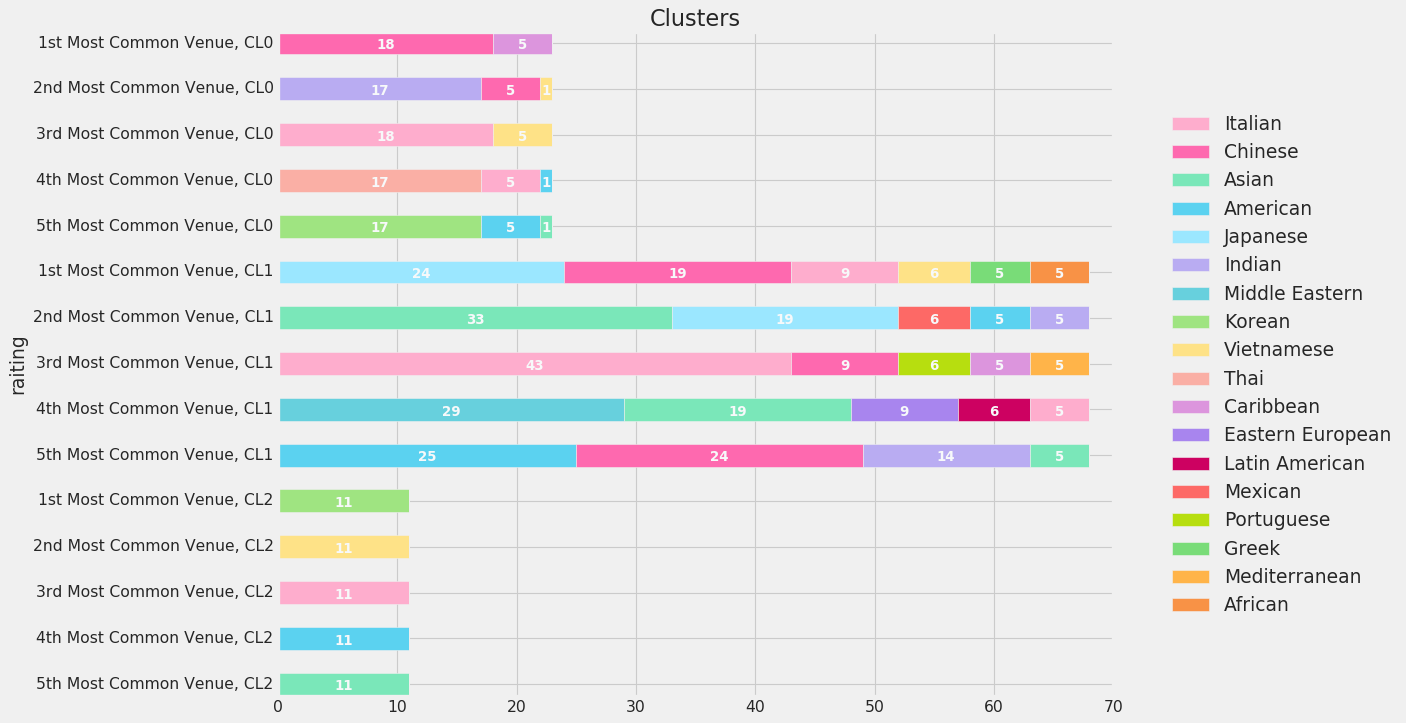

In [59]:
fig, ax = plt.subplots(figsize=(12,10))
x = x_all.index
indexes = np.argsort(x_all.values).T
widths = np.sort(x_all.values).T
order = -1
lefts = widths[::order].cumsum(axis=0)
lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

mpp_colors = dict(zip(x_all.columns, pastelcolors))

for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
    mps = np.take(np.array(x_all.columns), idxs)
    ax.barh(x, width=vals, height=0.5, left=lefts[k], color=[mpp_colors[m] for m in mps])  
for a in ax.patches:
    if a.get_width() != 0:
        ax.annotate(str(a.get_width()),(a.get_x()+a.get_width()/2,a.get_y()+0.2), color='#f7f9fa',fontsize=12,ha="center", va="center",fontweight="bold")
ax.set_title('Clusters')    
ax.set_ylabel('raiting')

#ax.legend((np.take(np.array(x_all.columns), np.argsort(x_all.values)[0]))[::order], bbox_to_anchor=(1.05, 0.9), loc='upper left', ncol=1)
ax.legend(handles[::-order],(np.array(x_all.columns))[::-order], bbox_to_anchor=(1.05, 0.9), loc='upper left', ncol=1)

### 28. I decided to combine choropleth and cluster map to see which places are attached to which cuisine & have more restaurants.

In [60]:

#‘OpenStreetMap’, ‘cartodbpositron’, ‘cartodbdark_matter’

toronto_map2 = folium.Map(location=[latitude, longitude], zoom_start=10,tiles='cartodbpositron')
toronto_map2.choropleth(geo_data=t_js,
    data = bn_grouped,
    columns=['FSA','Count'],
    key_on='feature.properties.CFSAUID',
    fill_color='Greys',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurant count') 
    
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Set3(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(topneighs_merged['Latitude'], topneighs_merged['Longitude'], topneighs_merged['Neighbourhood'], topneighs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map2)
    
toronto_map2